# Boosting
> **Boosting** (*Freud and Shapire, 1996*) - algorithm allowing to fit **many** weak classifiers to **reweighted** versions of the training data. Classify final examples by majority voting.

When using boosting techinque all instance in dataset are assigned a score that tells *how difficult to classify* they are. In each following iteration the algorithm pays more attention (assign bigger weights) to instances that were wrongly classified previously.

<img src='./resources/boosting.png' alt='boosting' style="width: 500px;"/>

In the first iteration all instance weights are equal.

Ensemble parameters are optimized in **stagewise way** which means that we are calculating optimal parameters for the next classifier holding fixed what was already calculated. This might sound like a limitation but turns out it's a very resonable way of regularizing the model.

### Weak classifier - why tree? <a name='weak-classifier' />
First what is a weak classifier?
> **Weak classifier** - an algorithm **slightly better** than random guessing.

Every algorithm can be used as a base for boosting techinique, but decision trees have some nice properties that makes them more suitable candidates.

#### Pro's
- computational scalability,
- handling missing values,
- robust to outliers,
- does not require feature scalling,
- can deal with irrelevant inputs,
- interpretable (if small),
- can handle mixed predictors (quantitive and qualitative)

#### Con's
- can't extract linear combination of features
- small predictive power (high variance)

Boosting techinque can try to reduce the variance by **averaging** many **different** trees (where each one is solving the same problem)

### Common Algorithms (warning MATH INCLUDED) <a name='common-algorithms' />

In every machine learning model the training objective is a sum of a loss function $L$ and regularization $\Omega$:

$$
obj = L + \Omega
$$

The loss function controls the predictive power of an algorithm and regularization term controls it's simplicity.
<br/><br/>

#### AdaBoost (Adaptive Boosting)
The implementation of boosting technique using decision tress (it's a *meta-estimator* which means you can fit any classifier in). The intuitive recipie is presented below:

**Algorithm**:

Assume that the number of training samples is denoted by $N$, and the number of iterations (created trees) is $M$. Notice that possible class outputs are $Y=\{-1,1\}$

1. Initialize the observation weights $w_i=\frac{1}{N}$ where $i = 1,2, \dots, N$
2. For $m=1$ to $M$:
    - fit a classifier $G_m(x)$ to the training data using weights $w_i$,
    - compute $err_m = \frac{\sum_{i=1}^{N} w_i I (y_i \neq G_m(x))}{\sum_{i=1}^{N}w_i}$,
    - compute $\alpha_m = \log ((1-err_m)/err_m)$,
    - set $w_i \leftarrow w_i \cdot \exp [\alpha_m \cdot I (y_i \neq G_m(x)]$, where $i = 1,2, \dots, N$
3. Output $G_m(x) = sign [\sum_{m=1}^{M} \alpha_m G_m(x)]$

<br/>
#### Generalized Boosted Models
We can take advantage of the fact that the loss function can be represented with a form suitable for optimalization (due to the stage-wise additivity). This creates a class of general boosting algorithms named simply **generalized boosted model (GBM)**.

An example of a GBM is **Gradient Boosted Tree** which uses decision tree as an estimator. It can work with different loss functions (regression, classification, risk modeling etc.), evaluate it's  gradient and approximates it with a simple tree (stage-wisely, that minimizes the overall error).

AdaBoost is a special case of Gradient Boosted Tree that uses exponential loss function. You can learn more about GBM in this [video](https://www.youtube.com/watch?v=wPqtzj5VZus&feature=youtu.be).

### How XGBoost helps 
<br/>
The problem with most tree packages is that they don't take regularization issues very seriously - they allow to grow many very similar trees that can be also sometimes quite bushy. 

GBT tries to approach this problem by adding some regularization parameters. We can:
- control tree structure (maximum depth, minimum samples per leaf),
- control learning rate (shrinkage),
- reduce variance by introducing randomness (stochastic gradient boosting - using random subsamples of instances and features)

But it could be improved even further. Enter XGBoost.

> **XGBoost** (*extreme gradient boosting*) is a **more regularized** version of Gradient Boosted Trees.

The main advantages:
- good bias-variance (simple-predictive) trade-off "out of the box",
- great computation speed,
- package is evolving (author is willing to accept many PR from community)

XGBoost's objective function is a sum of a specific loss function evaluated over all predictions and a sum of regularization term for all predictors ($K$ trees). In the formula $f_k$ means a prediction coming from k-th tree.

$$
obj(\theta) = \sum_{i}^{n} l(y_i - \hat{y_i}) +  \sum_{k=1}^{K} \Omega (f_k)
$$

Loss function depends on the task being performed (classification, regression, etc.) and a regularization term is described by the following equation:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2
$$

First part ($\gamma T$) is responsible for controlling the overall number of created leaves, and the second term ($\frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2$) watches over the their's scores. To optimize the objective a gradient descent is used, this leads to a problem of finding an optimal structure of the successive tree.

In [1]:
import numpy as np
import subprocess

from IPython.display import Image

from collections import Counter

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, accuracy_score

# classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# reproducibility
seed = 104

/Users/jkchang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Prepare data
In all examples we will be dealing with **binary classification**.  Generate 20 dimensional artificial dataset with 1000 samples, where 8 features holding information, 3 are redundant and 2 repeated.

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=seed)
# split training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

All algorithms won't be tuned at this point. A sensible set of default settings will be applied, making the whole things less complicated.

> [*Logarithmic loss*](https://www.kaggle.com/wiki/LogarithmicLoss) and accuracy were chosen to evaluate the results. It's also important to remeber about reproducibility - you should always set all `seed` parameters to the same value.

Let's perform a target variable distribution sanity check before digging into algorithms.

In [3]:
print("Train label distribution:")
print(Counter(y_train))

print("\nTest label distribution:")
print(Counter(y_test))

Train label distribution:
Counter({1: 404, 0: 396})

Test label distribution:
Counter({0: 106, 1: 94})


Target variable is equally distribued across both dataset.

### Single Decision Tree 
The following code will create a single decision tree, fit it using training data and evaluate the results using test sample.

In [4]:
decision_tree = DecisionTreeClassifier(random_state=seed)

# train classifier
decision_tree.fit(X_train, y_train)

# predict output
decision_tree_y_pred  = decision_tree.predict(X_test)
decision_tree_y_pred_prob  = decision_tree.predict_proba(X_test)

# evaluation
decision_tree_accuracy = accuracy_score(y_test, decision_tree_y_pred)
decision_tree_logloss = log_loss(y_test, decision_tree_y_pred_prob)

print("== Decision Tree ==")
print("Accuracy: {0:.2f}".format(decision_tree_accuracy))
print("Log loss: {0:.2f}".format(decision_tree_logloss))
print("Number of nodes created: {}".format(decision_tree.tree_.node_count))

== Decision Tree ==
Accuracy: 0.85
Log loss: 5.01
Number of nodes created: 143


We can see two things:

1. the log loss score is not very promising (due to the fact that leaves in decision tree outputs either `0` or `1` as probability which is heaviliy penalized in case of errors, but the accuracy score is quite decent,
2. the tree is complicated (large number of nodes)

You can inspect first few predicted outputs, and see that only 2 instances out of 5 were classified correctly.

In [5]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(decision_tree_y_pred[:5,])
print('\nPredicted probabilities:')
print(decision_tree_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 1 0 0 0]

Predicted probabilities:
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


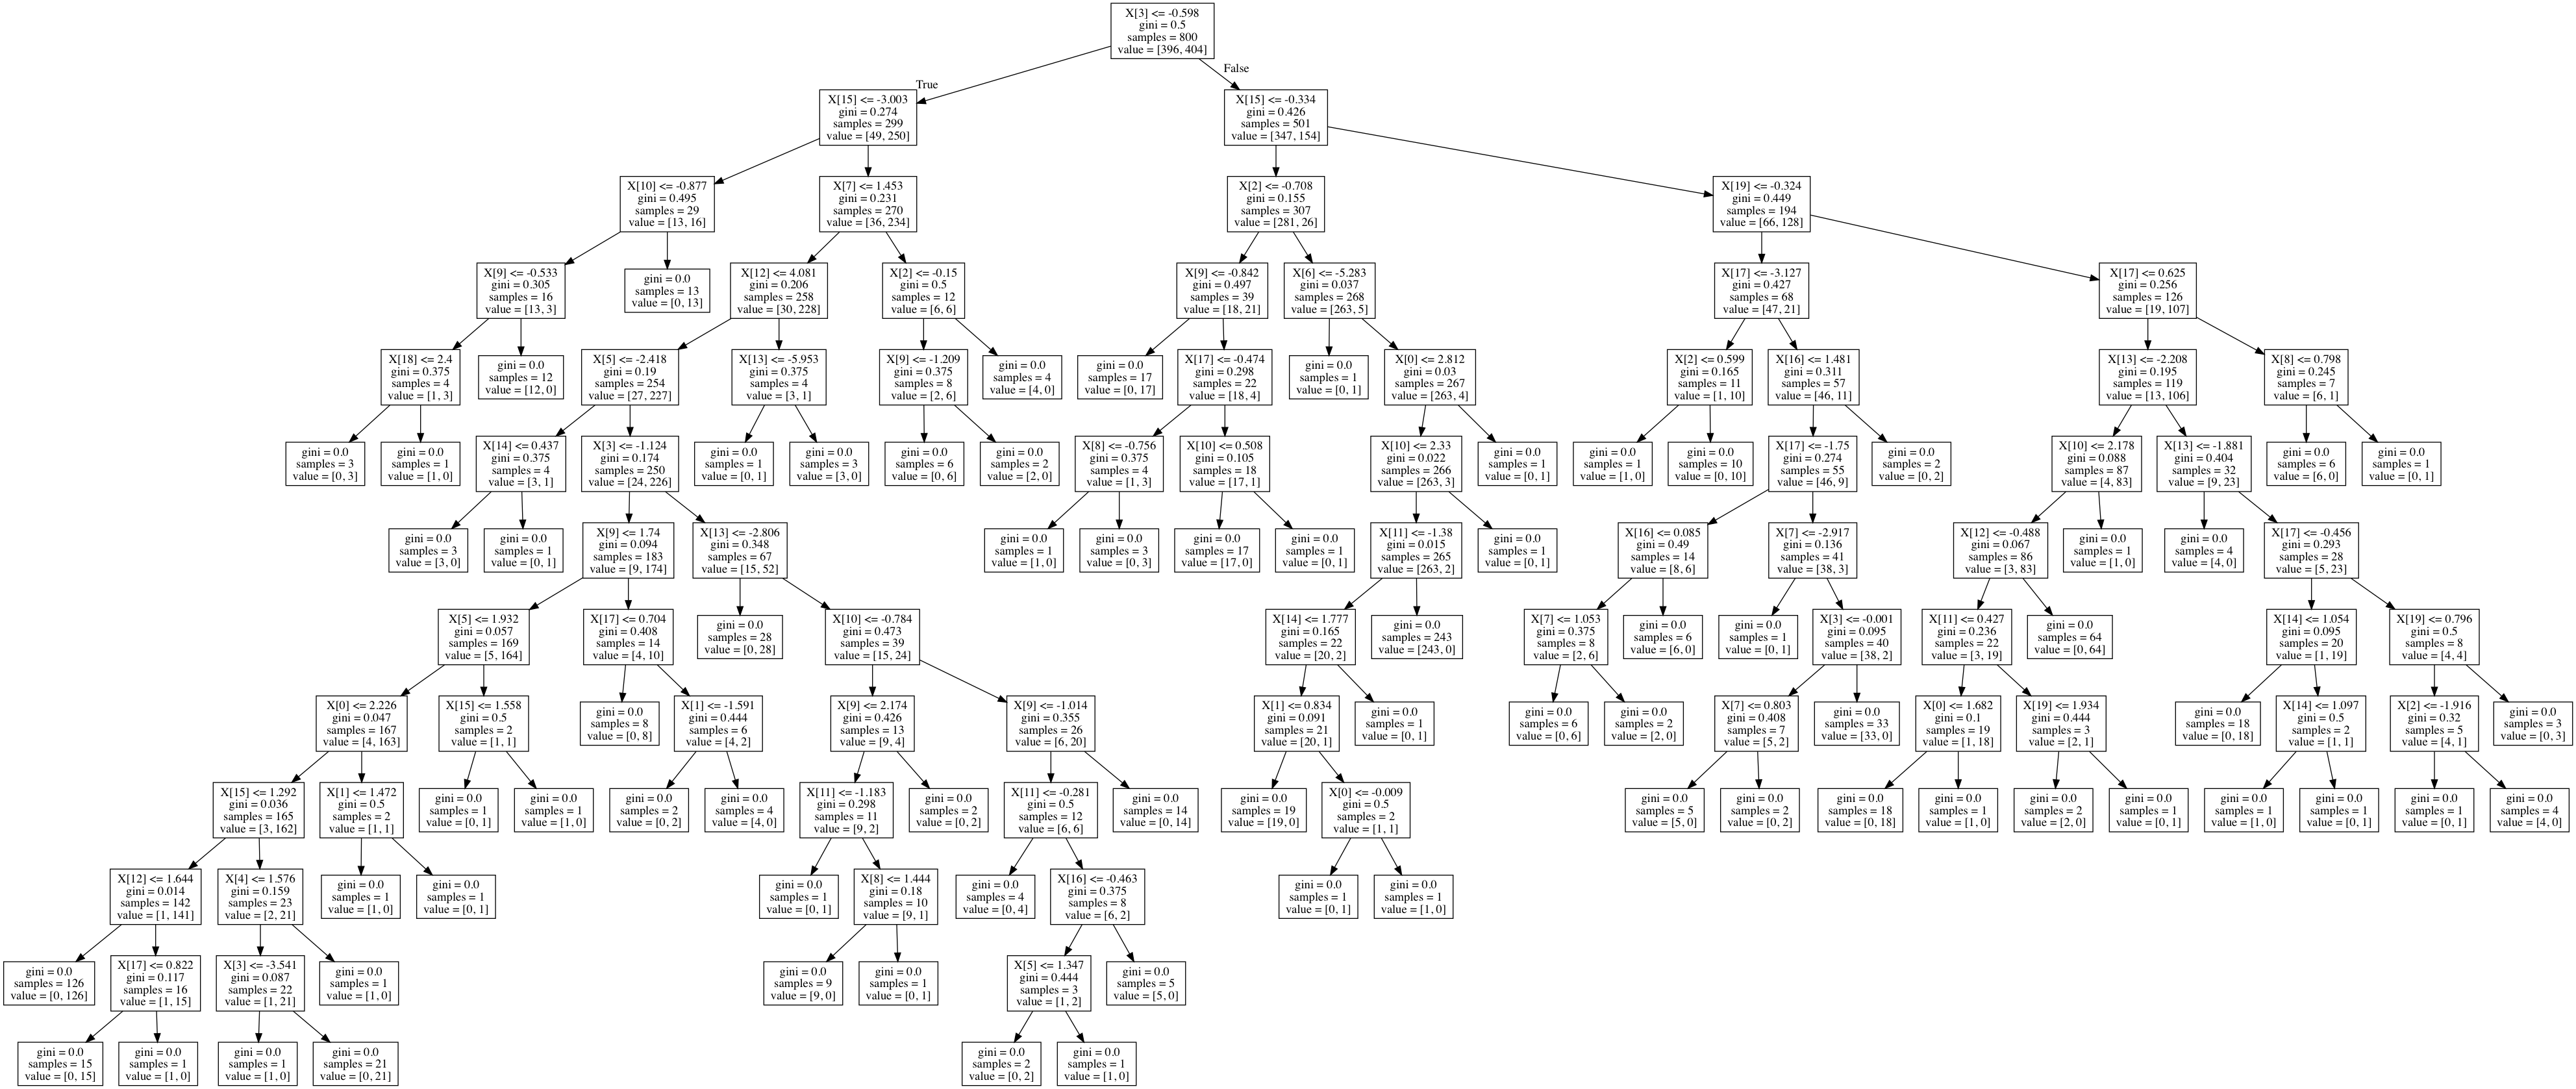

In [6]:
dt_viz_file = './resources/dt.dot'
dt_png_file = './resources/dt.png'

# create visualization
export_graphviz(decision_tree, out_file=dt_viz_file)

# convert to PNG
command = ["dot", "-Tpng", dt_viz_file, "-o", dt_png_file]
subprocess.check_call(command)

# display image
Image(filename=dt_png_file)

### AdaBoost <a name='ada' />
In the example below we are creating a AdaBoost classifier running on 1000 iterations (1000 trees created). Also we are growing decision node up to first split (they are called *decision stumps*). We are also going to use `SAMME` algorithm which is inteneded to work with discrete data (output from `base_estimator` is `0` or `1`). Please refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and [here](http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html) for more details.

In [7]:
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME',
    n_estimators=1000,
    random_state=seed)

# train classifier
adaboost.fit(X_train, y_train)

# calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

# evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

print("== AdaBoost ==")
print("Accuracy: {0:.2f}".format(adaboost_accuracy))
print("Log loss: {0:.2f}".format(adaboost_logloss))

== AdaBoost ==
Accuracy: 0.84
Log loss: 0.68


The log-loss metrics is much lower than in single decision tree (mainly to the fact that now we obtain probabilities output). The accuracy is the same, but notice that the structure of the tree is much simpler. We are creating 1000 **decision tree stumps**.

Also here a quick peek into predicted values show that now 4 out of 5 first test instances are classified correctly.

In [8]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(adaboost_y_pred[:5,])
print('\nPredicted probabilities:')
print(adaboost_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 0 0 0 0]

Predicted probabilities:
[[0.48396329 0.51603671]
 [0.49868559 0.50131441]
 [0.49892766 0.50107234]
 [0.50151698 0.49848302]
 [0.50566436 0.49433564]]


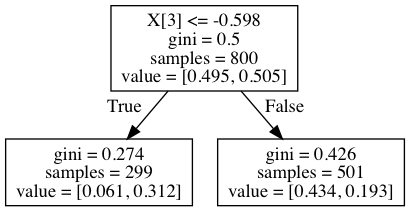

In [9]:
ada_t1 = adaboost.estimators_[0]
ada_t1_viz_file = './resources/ada-t1.dot'
ada_t1_png_file = './resources/ada-t1.png'

# create visualization
export_graphviz(ada_t1, out_file=ada_t1_viz_file)

# convert to PNG
command = ["dot", "-Tpng", ada_t1_viz_file, "-o", ada_t1_png_file]
subprocess.check_call(command)

# display image
Image(filename=ada_t1_png_file)

In [10]:
print("Error: {0:.2f}".format(adaboost.estimator_errors_[0]))
print("Tree importance: {0:.2f}".format(adaboost.estimator_weights_[0]))

Error: 0.25
Tree importance: 1.08


### Gradient Boosted Trees<a name='gbt' />
Let's construct a gradient boosted tree consiting of 1000 trees where each successive one will be created with gradient optimization. Again we are going to leave most parameters with their default values, specifiy only maximum depth of the tree to 1 (again decision stumps), and setting warm start for more intelligent computations. Please refer to the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) if something is not clear.

In [11]:
gbc = GradientBoostingClassifier(
    max_depth=1,
    n_estimators=1000,
    warm_start=True,
    random_state=seed)
gbc.fit(X_train, y_train)

# make predictions
gbc_y_pred = gbc.predict(X_test)
gbc_y_pred_prob = gbc.predict_proba(X_test)

# calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.84
Log loss: 0.34


The obtained results are obviously the best of all presented algorithm. We have obtained most accurate algorithm giving more sensible predictions about class probabilities.

In [12]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(gbc_y_pred[:5,])
print('\nPredicted probabilities:')
print(gbc_y_pred_prob[:5,])

True labels:
[1 1 0 0 0]

Predicted labels:
[1 0 0 0 0]

Predicted probabilities:
[[0.12344095 0.87655905]
 [0.69217302 0.30782698]
 [0.83598136 0.16401864]
 [0.9159873  0.0840127 ]
 [0.99863653 0.00136347]]


The difference is that GBC uses `DecisionTreeRegressor` classifier as the estimator with *mean-square error* as criterion. This results of slightly different output of the tree - now the leaf contains a predicted value (while the first splitting point remains the same).

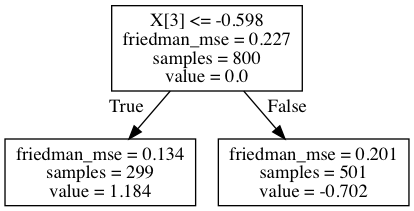

In [13]:
gbc_t1 = gbc.estimators_[2][0]
gbc_t1_viz_file = './resources/gbc-t1.dot'
gbc_t1_png_file = './resources/gbc-t1.png'

# create visualization
export_graphviz(gbc_t1, out_file=gbc_t1_viz_file)

# convert to PNG
command = ["dot", "-Tpng", gbc_t1_viz_file, "-o", gbc_t1_png_file]
subprocess.check_call(command)

# display image
Image(filename=gbc_t1_png_file)